In [2]:
import numpy as np
#import threading
#import socket
#import struct
import requests
import time
import matplotlib.pyplot as plt
import serial
%matplotlib inline

In [3]:
#plotting formatting
plt.rc('font', family ='serif')
plt.rc('xtick',labelsize = 'x-large')
plt.rc('ytick',labelsize = 'x-large')

In [4]:
def sample_spectrum(samples=1024):
    """ Remotely samples spectrum with Kotekan.
    
    Parameters
    ----------
    samples : float 
        Numer of samples reciever records.
    """
    url = 'http://localhost:12048/spectrum_output/xengine/spectrum'
    payload = '{"integration_length":%d}'%(samples)
    headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
    r = requests.post(url, data=payload, headers=headers)
    return r.json()

def set_freq(freq):
    """ Sets center of 20 MHz frequency band spanned by reciever romotely with Kotekan.
    
    Parameters
    ----------
    freq : float
        Desired center of frequency band.
    """
    url = 'http://localhost:12048/airspy_input/config'
    payload = '{"freq":%d}' %(freq)
    headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
    r = requests.post(url, data=payload, headers=headers)
    return r

def set_gain(lna=10,mix=10,ifa=10):
    """ Sets gain field parameters of reciever romotely with Kotekan.
    
    Gain fields range from 0-14, with normal values around 10, and higher gains at higher numerical values.
    Parameters
    ----------
    lna : float
        Gain field.
        
    mix : float
        Gain field.
        
    ifa : float
        Gain field.
    
    Returns
    -------
    mean : 
        Mean value of  ADC samples.
        
    railfrac :
       Fraction of samples railed (overloaded) the ADC. Typically this should be = 0.
    
    rms : 
       RMS (Root Mean Square) of the ADC samples. Typically this should be ≳ 300.
    """
    url = 'http://localhost:12048/airspy_input/config'
    payload = '{"gain_lna":%d, "gain_mix":%d, "gain_if":%d}' %(lna,mix,ifa)
    headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
    r = requests.post(url, data=payload, headers=headers)
    return r.json()    

def init_ns():
    """
    Connects to Trinket M0 microcontroller via USB.
    """
    return serial.Serial('/dev/ttyACM0', 115200)

def close_ns(s):
    """
    Closes serial port connected to Trinket M0 microcontroller via USB.
    """
    s.close()
    return

def toggle_ns(s,powered=False):
    """
    Controls Trinket M0 pin connected to Boolean controlled switch.
    Parameters
    ----------
    s: 
    Serial Port
    powered: Boolean
        Controls the state of the switch False = off, True = on.
    """
    if powered:
        s.write('on\r'.encode())
    else:
        s.write('off\r'.encode())
    return

In [5]:
#my functions 
def mean_power(spec):
    """ Determines mean value of power spectrum.
    
    First trimms the spectra to remove the roll-off that occurs at the high and low ends of the spectrum /
    then creates a mask which enables frequencies within the band that have a power output within the /
    range of two factors of the standard deviation of the median power.
    
    Paramters 
    ---------
    spec : array
        Recorded spectrum outputed from get_spectra()
        
    Returns
    -------
    meanpower : float
        Mean value of masked spectrum.
    """
    cropspec = spec[128:-128]
    medpower = np.median(cropspec)
    stdpower = np.std(cropspec)
    
    good_data = []
    for i in cropspec:
        if (i < medpower+2*stdpower) and (i > medpower-2*stdpower):
            good_data.append(i)
    
    meanpower =np.mean(good_data)
    return meanpower

def y(on,off):
    """
    Determines the Y-factor of two values.
    
    The Y-factor of two values is defined to be y = s_on/s_off.
    Parameters
    ----------
    s_on : float
        Average value of power spectrum with noise source on.
    
    s_off : float
        Average value of power spectrum with noise source off.
    
    Returns
    -------
    Y : float
        quotient of s_on, s_off.
    """
    Y = on/off
    return Y

def enr(f):
    """ Determines the Excess Noise Ratio (ENR) of the system.
    
    This function interpolates the numerical values documented on the Keysight 346A Noise Source Calibration Label.
    Parameters
    ----------
    f : float
        Observation frequency.
    
    Returns
    -------
    ENR : float
        ENR value at obervation frequency in decimal form.
    
    ENR_dB: float
        ENR value at obervation frequency in decibel units.
    """
    f_vals = np.array([0.01,0.1,1.0,2.0,3.0])
    enr_vals = np.array([5.20,5.38,5.19,5.01,4.85])
    ENR_dB = np.interp(f, f_vals*1e3, enr_vals)
    ENR = 10**(ENR_dB/10)
    return ENR, ENR_dB

def y2NF(ENR,y_val):
    """ Calculates noise factor from y-factor.
    
    Parameters
    ----------
    ENR : float
        ENR value at obervation frequency in decimal form.
    
    y_val : float
        Y-factor obtained from y(s_on,s_off).
        
    Returns
    -------
    nf : float
        Noise factor defined by 290*np.log10(ENR/(y_val-1)).
    """
    nf = 290*np.log10(ENR/(y_val-1))
    return nf

def NF2T(nf):
    """ Calculates noise temperature from noise factor.
    
    Parameters
    ----------
    nf : float
      Noise factor at obervation frequency in decimal form.
    
    Returns
    -------
    Tn : float
        Noise temperature defined by 290*(10**(nf/10)-1).
    """
    return 290*(10**(nf/10)-1)

#### Practice measuring $T_n$

In [6]:
set_freq(900)
s = init_ns()

In [7]:
set_gain(lna=10,mix=10,ifa=10)

{'mean': 18.70477294921875, 'railfrac': 0.0, 'rms': 298.8042907714844}

In [8]:
toggle_ns(s,powered=0)
s_off=np.array(sample_spectrum(1024)['stokes_i'])
time.sleep(0.1)
toggle_ns(s,powered=1)
s_on=np.array(sample_spectrum(1024)['stokes_i'])
toggle_ns(s,powered=0)

In [12]:
ya = y(mean_power(s_on),mean_power(s_off))
ya

3.493313816373509

In [11]:
ENR = enr(800)[0]
ENR

3.3359706590602944

In [13]:
NF = y2NF(ENR,ya)
NF

36.669130793787346

In [14]:
def measure_Tn(f, s_on,s_off, enr):
    """ Determines noise temperature of a device in testing.
    
    Determines noise temperature from power spectra at a specified frequency with a linear regression /
    generates graphical representation of results.
    
    Parameters
    ----------
    f : float
        Specified frequency.
    s_on : array
        Power spectra with noise source on.
        
    s_off : array
        Power spectra with noise source off.
        
    enr : float
        Excess Noise Ratio (ENR) at specified frequency
    """
    #Plot measured power and inut power vs T:
    power_ns_on = mean_power(s_on)
    power_ns_off = mean_power(s_off)

    T_ns_off = 290 #K
    T_ns_on = 290*(enr+1)

    m,b = np.polyfit((T_ns_on,T_ns_off),(power_ns_on,power_ns_off),1)
    x = np.linspace(-100,1600,50)

    def linear(x):
        return m*x+b

    #find and plot x-int, y-int
    y_int = round(linear(0),2)

    T_LNA = round(linear(0)/m,2)
    
    fig, ax = plt.subplots(1, figsize = (10,8))
    ax.plot(T_ns_off,power_ns_off, marker = 'o', color = 'red',linestyle = None, markeredgecolor = 'black', markersize = 8, label = r'($P_{ns\;off},T_{ns\;off}$)')
    ax.plot(T_ns_on,power_ns_on,  marker = 'o', color = 'green', linestyle = None, markeredgecolor = 'black', markersize = 8, label = r'($P_{ns\;on},T_{ns\;on}$)')

    #plot y-int
    ax.plot(0,y_int,  marker = 'D', color = 'grey', linestyle = None, markeredgecolor = 'black', markersize = 8)

    #plot line of best fit
    ax.plot(x,linear(x), '-b', alpha = 0.4, label = f'Linear Regression y = {round(m,2)}x+{round(b,2)}')
    
    #annotate y-intercept
    ax.annotate(f'$y_{{int}}$ = (0,{y_int})', (0,y_int), (0+50,y_int-10000000), fontsize = 12)

    #plt.grid()
    ax.set_title(f'Power vs Temperature at $f={f}\; MHz$', fontsize = 18)
    ax.set_xlabel('Temperature [K]', fontsize = 15)
    ax.set_ylabel(r'Power [$bits^2$]', fontsize = 15)
    ax.set_xlim(-100,1600)
    ax.legend(fontsize=12)

    txt1 = r'$T_{{LNA}} =\; \frac{y_{intercept}}{\mathrm{slope}}$ ='+ f' {T_LNA} K'
    ax.text(500,-2e8,txt1, fontsize = 15)

    fig.tight_layout()
    fig.savefig('yfactor_900')

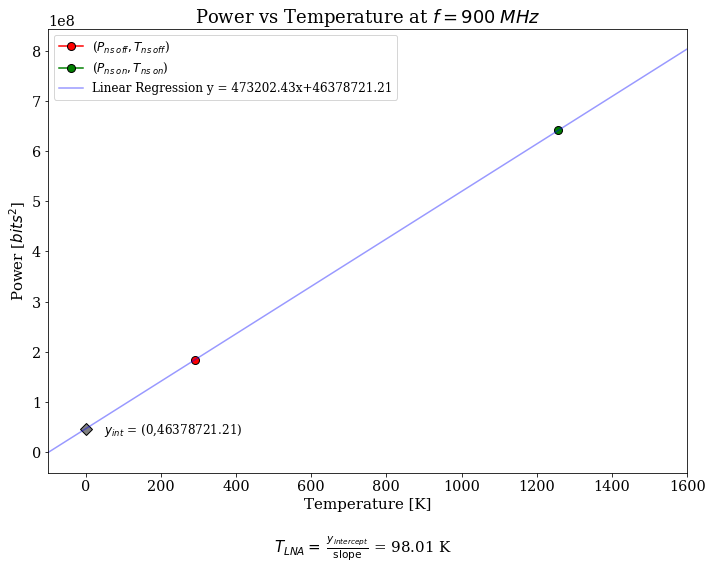

In [15]:
measure_Tn(900, s_on,s_off, ENR)

##### Frequency sweep function 

In [16]:
def NTM(freq_list,ifa):
    """ Automated noise frequency meter for Device Under Testing (DUT)
    
    Remotely records power spectra at optimal gain frequency over specified frequency band, /
    determines average of spectrum, determines load temperatures at specified frequency, and applies /
    linear regression to determine noise temperaure of DUT.
    
    Parameters
    ----------
    freq_list : array
        Frequency band of DUT.
        
    ifa : float
        Initial gain feild parameter.
    
    Returns
    -------
    T_DUT : Array
        (frequency, noise temperature of DUT)
    
    """
    s = init_ns()
    
    T_list = []
    for i,f in enumerate(freq_list):
        set_freq(f)
        #automated optimal gain setting 
        g = set_gain(lna=ifa,mix=ifa,ifa=ifa)
        if g['railfrac']>0:
            ifa=ifa-1
            g = set_gain(lna=ifa,mix=ifa,ifa=ifa)
        if g['rms']<300:
            ifa=ifa+1
            g = set_gain(lna=ifa,mix=ifa,ifa=ifa)
            
        toggle_ns(s,powered=0)
        s_off=np.array(sample_spectrum(1024)['stokes_i'])
        time.sleep(0.1)
        toggle_ns(s,powered=1)
        s_on=np.array(sample_spectrum(1024)['stokes_i'])
        toggle_ns(s,powered=0)
        
        Pon_avg = np.mean(s_on)
        Poff_avg = np.mean(s_off)
        ya = y(Pon_avg,Poff_avg)
        ENR = enr(f)[0]
        
        T_load_off = 290 
        T_load_on = 290*(ENR+1)
        
        m,b = np.polyfit((T_load_off,T_load_on),(Poff_avg,Pon_avg),1)
        x = np.linspace(0,2000,50)

        def linear(x, m=m , b=b):
            return m*x+b

        #find yint => T_LNA
        G = linear(0)
        T_LNA = G/m
        T_list.append(T_LNA)
        
    s.close()  
    
    return T_list

In [17]:
freqs = np.arange(1100,400,-25)
T_list = NTM(freqs, 10)

##### Plot $T_{LNA}$ Data over frequency band

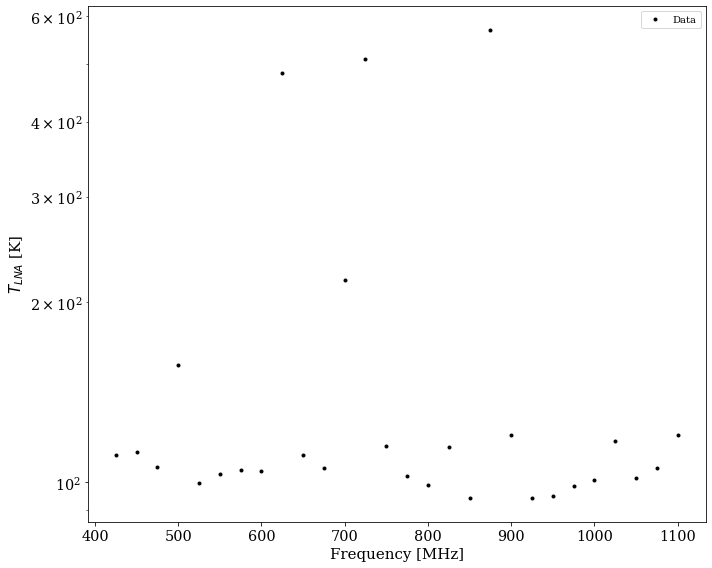

In [18]:
fig, ax = plt.subplots(1, figsize = (10,8))

ax.semilogy(freqs,T_list, '.k', label = 'Data')
ax.set_xlabel('Frequency [MHz]', fontsize = 15)
ax.set_ylabel(r'$T_{LNA}$ [K]', fontsize = 15)
ax.legend()
fig.tight_layout()

##### Read in $T_{LNA}$ data obtained from insturment data sheet (https://www.minicircuits.com/pdfs/ZX60-112LN+.pdf) 

In [19]:
NF = np.array([1.27,1.24,1.20,1.18,1.18,1.16,1.13,1.14,1.14,1.09,1.11,1.11,1.18,1.22,1.27])
f = np.array([400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100])

def NF2T(NF):
    T_amb = 290
    return T_amb*(10**(NF/10)-1)

T = NF2T(NF)

##### Overlay documented $T_{LNA}$ data over $\texttt{NTM()}$ Output

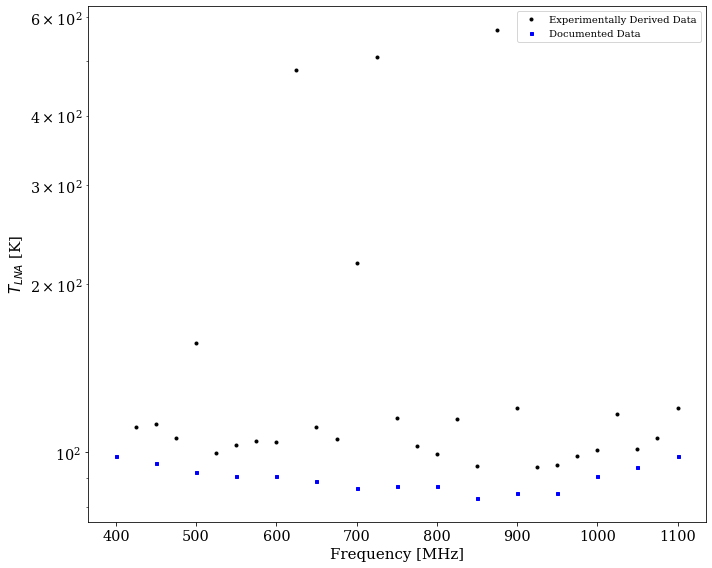

In [20]:
fig, ax = plt.subplots(1, figsize = (10,8))

ax.semilogy(freqs,T_list, '.k', label = 'Experimentally Derived Data')
ax.semilogy(f,T, 'sb', markersize= 3, label = 'Documented Data')
ax.set_xlabel('Frequency [MHz]', fontsize = 15)
ax.set_ylabel(r'$T_{LNA}$ [K]', fontsize = 15)
ax.legend()
fig.tight_layout()
fig.savefig('TLNA_comp')